# IMPORTACION DE LIBRERIAS

In [ ]:
import pandas as pd
import seaborn as sbn
import pydot
from IPython.display import Image
from sklearn import tree
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from joblib import dump, load

# PREPROCESAMIENTO

Importación de los datos del dataset y Mostrar las primeras y últimas filas del dataframe y Mostrar las primeras y últimas filas del dataframe importado

In [ ]:
wines = pd.read_csv('/content/WineQT.csv')
wines = wines.drop('Id', axis = 1)
wines

fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
0               7.4             0.700         0.00  ...       0.56      9.4        5
1               7.8             0.880         0.00  ...       0.68      9.8        5
2               7.8             0.760         0.04  ...       0.65      9.8        5
3              11.2             0.280         0.56  ...       0.58      9.8        6
4               7.4             0.700         0.00  ...       0.56      9.4        5
...             ...               ...          ...  ...        ...      ...      ...
1138            6.3             0.510         0.13  ...       0.75     11.0        6
1139            6.8             0.620         0.08  ...       0.82      9.5        6
1140            6.2             0.600         0.08  ...       0.58     10.5        5
1141            5.9             0.550         0.10  ...       0.76     11.2        6
1142            5.9             0.645         0.12  ...       0.71     10.2        5

[1143 rows x 12 columns]

Mostrar parámetros estadísticos de los datos

In [ ]:
wines.describe()

fixed acidity  volatile acidity  ...      alcohol      quality
count    1143.000000       1143.000000  ...  1143.000000  1143.000000
mean        8.311111          0.531339  ...    10.442111     5.657043
std         1.747595          0.179633  ...     1.082196     0.805824
min         4.600000          0.120000  ...     8.400000     3.000000
25%         7.100000          0.392500  ...     9.500000     5.000000
50%         7.900000          0.520000  ...    10.200000     6.000000
75%         9.100000          0.640000  ...    11.100000     6.000000
max        15.900000          1.580000  ...    14.900000     8.000000

[8 rows x 12 columns]

Mostrar un mapa de calor que indique la correlación entre variables

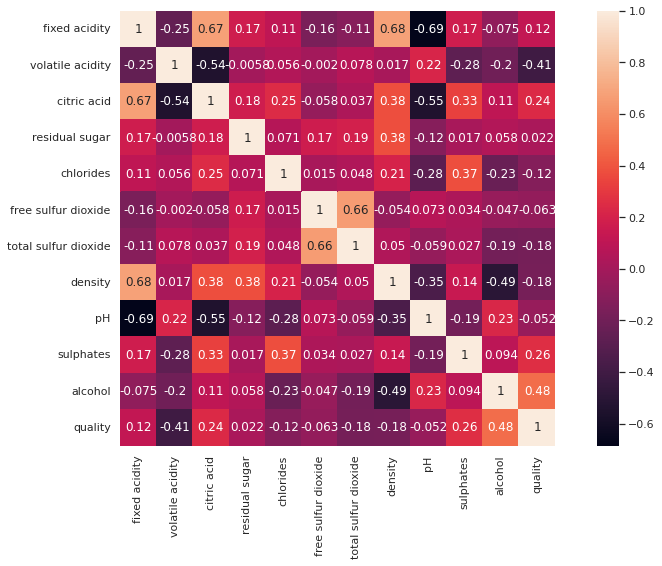

In [ ]:
sbn.set(rc = {'figure.figsize':(15,8)})
sbn.heatmap(wines.corr(), square=True, annot=True)

Seleccionar las características a tener en cuenta en el estudio. Se usan todas


Separar datos entre datos de entrada y etiquetas (resultados)

In [ ]:
x_wine = wines.drop('quality', axis = 1)
y_wine = wines['quality']
y_wine


0       5
1       5
2       5
3       6
4       5
       ..
1138    6
1139    6
1140    5
1141    6
1142    5
Name: quality, Length: 1143, dtype: int64

Separar datos entre entrenamiento y prueba (usando un 80% para entrenamiento y 20% para test)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_wine,y_wine, random_state=1, test_size=0.2)

# ENTRENAMIENTO Y PREDICCION

Elegir, instanciar (eligiendo unos valores concretos, por ejemplo profundidad del árbol 3) y entrenar el modelo

In [ ]:
model = DecisionTreeClassifier(criterion='gini',max_depth=3)
model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3)

Realizar una predicción con los datos de prueba

In [ ]:
y_model = model.predict(x_test)

Mostrar el árbol de decisión resultante

In [ ]:
wines_str = wines['quality'].astype(str)
result = []
for item in wines_str:
    if item not in result:
        result.append(item)
result

['5', '6', '7', '4', '8', '3']

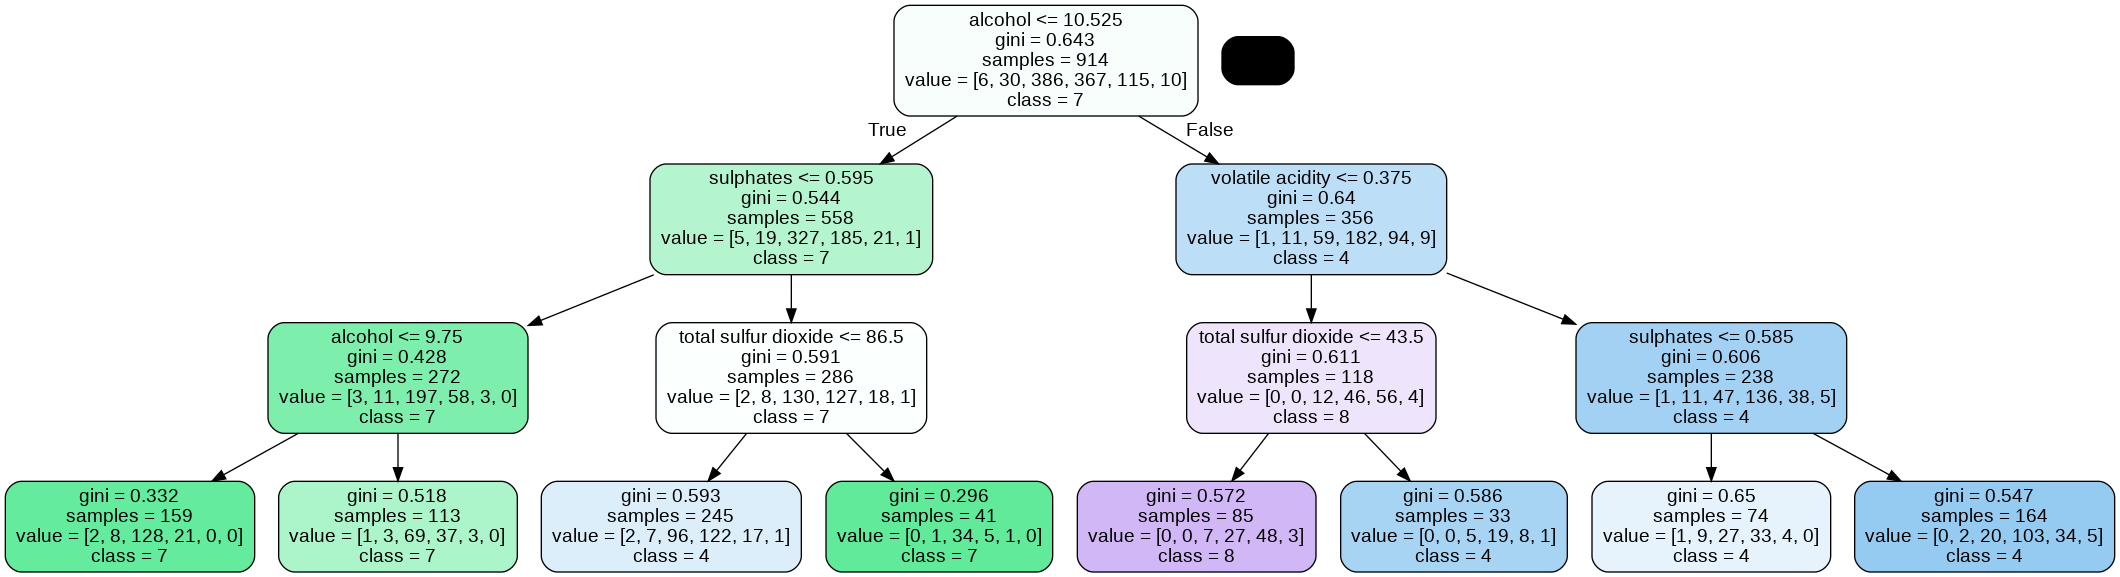

In [ ]:
dot_data = StringIO()
tree.export_graphviz(model, out_file= dot_data, rounded=True, class_names=result ,feature_names= x_train.columns, filled = True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

Mostrar la importancia de cada atributo en el árbol resultante

In [ ]:
model.feature_importances_

array([0.        , 0.09976855, 0.        , 0.        , 0.        ,
       0.        , 0.14023591, 0.        , 0.        , 0.21602452,
       0.54397102])

Almacenar el modelo de prediccion

In [ ]:
dump(model, 'vinos.joblib') 

['vinos.joblib']

In [ ]:
model_load = load('vinos.joblib')
model_load

DecisionTreeClassifier(max_depth=3)

# EVALUACION

Mostrar el porcentaje de elementos correctamente clasificados

In [ ]:
accuracy_score(y_test,y_model)

0.5676855895196506

Mostrar la predicción realizada (imprimir la variable con la predicción)

In [ ]:
for i in (0,len(y_model)-1):
  print("prediccion: {a} real: {b}".format(a = y_model[i], b = y_wine[i]))

prediccion: 6 real: 5
prediccion: 6 real: 6


 Representar gráficamente la clasificación obtenida (matriz de confusión)

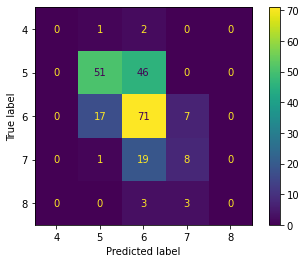

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,y_model)

# OPTIMIZACION


In [ ]:
# parámetros: modelo, los datos de entrenamiento separados (x, y)
# y el KFold con los splits
# devuelve la media de las ejecuciones
def validacion_cruzada_cl(model, x, y, kf):
  fold_accuracy = []
  for train_fold, test_fold in kf.split(x):
    # obtengo cada partición
    x_train_fold = x.iloc[train_fold]
    y_train_fold = y.iloc[train_fold]
    x_test_fold = x.iloc[test_fold]
    y_test_fold = y.iloc[test_fold]
    # entrenamiento
    model.fit(x_train_fold, y_train_fold)
    # predicción
    y_pred = model.predict(x_test_fold)
    # evaluación del modelo
    acc = accuracy_score(y_test_fold, y_pred)
    fold_accuracy.append(acc)
  media_score = sum(fold_accuracy)/len(fold_accuracy)
  return media_score

In [ ]:
kf = KFold(n_splits = 5)

for w in ['gini','entropy']:
  for k in range(1,16):
    model_opti = DecisionTreeClassifier(criterion=w, max_depth=k)
    media_cruzada = validacion_cruzada_cl(model_opti,x_train,y_train,kf)
    print("Para k: {k} y w: {w} la media es: {m}".format(k=k,w=w,m=media_cruzada))


Para k: 1 y w: gini la media es: 0.5525250705578575
Para k: 2 y w: gini la media es: 0.5350387317600432
Para k: 3 y w: gini la media es: 0.5656938689725576
Para k: 4 y w: gini la media es: 0.5503873176004324
Para k: 5 y w: gini la media es: 0.5722392361736623
Para k: 6 y w: gini la media es: 0.571146339998799
Para k: 7 y w: gini la media es: 0.556896655257311
Para k: 8 y w: gini la media es: 0.5656218098841049
Para k: 9 y w: gini la media es: 0.5437458716147241
Para k: 10 y w: gini la media es: 0.5492343721851919
Para k: 11 y w: gini la media es: 0.550309253587942
Para k: 12 y w: gini la media es: 0.542664985287936
Para k: 13 y w: gini la media es: 0.5393622770671951
Para k: 14 y w: gini la media es: 0.5306371224404011
Para k: 15 y w: gini la media es: 0.5339038011169158
Para k: 1 y w: entropy la media es: 0.556896655257311
Para k: 2 y w: entropy la media es: 0.5394103164594968
Para k: 3 y w: entropy la media es: 0.5416381432774876
Para k: 4 y w: entropy la media es: 0.5448808022578515

In [ ]:

for w in ['gini','entropy']:
  for k in range(1,16):
    model_opti = DecisionTreeClassifier(criterion=w, max_depth=k)
    media_cruzada = validacion_cruzada_cl(model_opti,x_train,y_train,kf)
    if media_cruzada > 0.57:
      print("Para k: {k} y w: {w} la media es: {m}".format(k=k,w=w,m=media_cruzada))
      model_graf = model_opti
      

NameError: ignored

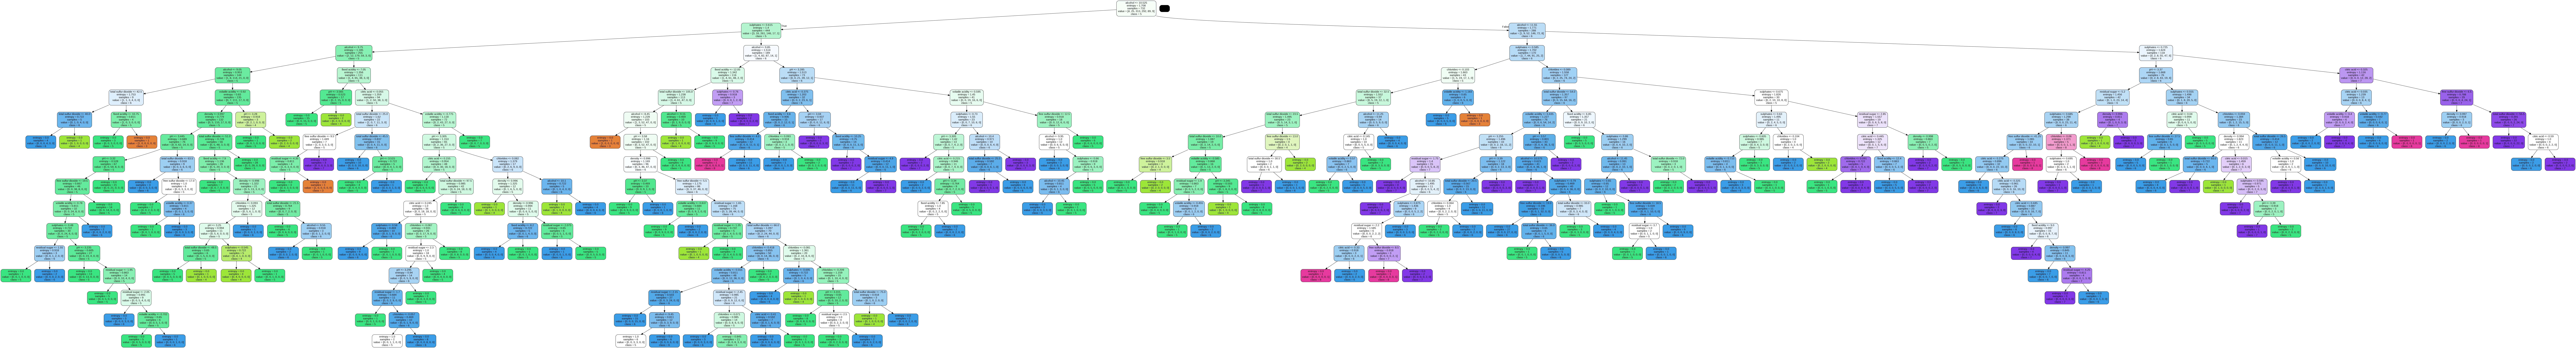

In [ ]:
dot_data2 = StringIO()
tree.export_graphviz(model_opti, out_file= dot_data2, rounded=True,class_names=result ,feature_names= x_train.columns, filled = True)

graph2 = pydot.graph_from_dot_data(dot_data2.getvalue())
Image(graph2[0].create_png())